In [1]:
# === 1. Importación de librerías ===
# Ignorar advertencias
import warnings
warnings.filterwarnings("ignore")

# Utilidades del sistema y fechas
import os
from pathlib import Path
from datetime import datetime, timedelta

# Manipulación de datos
import pandas as pd
import numpy as np

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocesamiento y modelado
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    RocCurveDisplay, precision_recall_curve, PrecisionRecallDisplay,
    recall_score, precision_score, f1_score
)
from imblearn.combine import SMOTETomek
from xgboost import XGBClassifier

In [2]:
# === 2. Carga y consolidación de archivos CSV ===
ruta_validaciones = Path(r"C:\Users\DiegoEveraldoFernand\CASG-POMA S.A.S Y SOFRATESA INC\CASG - 04. COM EST&PMC\6 REC-ADM\PMC\DFE\CASG\Virgen\VALIDACIONES\2024")
archivos_csv = list(ruta_validaciones.rglob("*.csv"))

columnas_necesarias = [
    "Date", "EquipmentModel", "Equipment", "ProfileName",
    "StopPlaceShortName", "SupportId", "TransactionType", "ValidationTicket"
]

dataframes = [
    pd.read_csv(archivo, encoding='utf-8', sep=None, engine='python', usecols=columnas_necesarias)
    for archivo in archivos_csv
]
df_total = pd.concat(dataframes, ignore_index=True)
print(f"El dataframe tiene {len(df_total):,} registros.")

El dataframe tiene 5,507,351 registros.


In [3]:
# === 3. Limpieza y transformación de datos ===
df_total = df_total[
    (~df_total["ProfileName"].isin(["Agente", "Estandar"])) &
    (df_total["EquipmentModel"] != "Validadora Bus")
].copy()

df_total["TransactionType"] = df_total["TransactionType"].replace("CORRESPONDENCE_ENTRY", "ENTRY")
df_total["StopPlaceShortName"] = df_total["StopPlaceShortName"].replace("Bus Durán", "Durán")
df_total[["Date", "Hour"]] = df_total["Date"].astype(str).str.split("T", expand=True)
df_total["Hour"] = df_total["Hour"].str.split(".", n=1).str[0]

print(f"Registros después de limpieza: {len(df_total):,}")

# Conteo de registros por tipo de perfil
print("\nRegistros por tipo de ProfileName:")
print(df_total["ProfileName"].value_counts())

Registros después de limpieza: 705,166

Registros por tipo de ProfileName:
ProfileName
Tercera edad                       201474
Estudiante                         171547
Personas con Movilidad Reducida     87278
Name: count, dtype: int64


In [4]:
# === 4. Generación de viajes y etiquetado de fraude ===
# Filtrar validaciones correctas y construir lista negra
df_validaciones = df_total[df_total["ValidationTicket"] == "RETURN_CODE_OK"].copy()
df_lista_negra = df_total[df_total["ValidationTicket"].isin([
    "RETURN_CODE_MEDIA_BLACKLIST", "RETURN_CODE_MEDIA_INVALIDATED"
])].drop_duplicates("SupportId")

# Preparar entradas y salidas
df_validaciones["DateTime"] = pd.to_datetime(df_validaciones["Date"] + " " + df_validaciones["Hour"])
df_entry = df_validaciones[df_validaciones["TransactionType"] == "ENTRY"]
df_exit = df_validaciones[df_validaciones["TransactionType"] == "EXIT"]

# Generar viajes
viajes = []
umbral_max = timedelta(minutes=20)

for support_id, entradas in df_entry.groupby("SupportId"):
    salidas = df_exit[df_exit["SupportId"] == support_id].copy()
    entradas = entradas.sort_values("DateTime")
    salidas = salidas.sort_values("DateTime")

    for _, entrada in entradas.iterrows():
        posibles_salidas = salidas[
            (salidas["DateTime"] > entrada["DateTime"]) &
            (salidas["DateTime"] - entrada["DateTime"] <= umbral_max)
        ]

        if not posibles_salidas.empty:
            salida = posibles_salidas.iloc[0]
            multival = not entradas[
                (entradas["DateTime"] > entrada["DateTime"]) &
                (entradas["DateTime"] < salida["DateTime"])
            ].empty
            duracion = salida["DateTime"] - entrada["DateTime"]
            tiempo_min = duracion.total_seconds() / 60

            viajes.append({
                "SupportId": entrada["SupportId"],
                "Fecha": entrada["Date"],
                "Hora_Ingreso": entrada["Hour"],
                "Hora_Salida": salida["Hour"],
                "Estación_Ingreso": entrada["StopPlaceShortName"],
                "Estación_Salida": salida["StopPlaceShortName"],
                "Equipment_Ingreso": entrada["Equipment"],
                "Equipment_Salida": salida["Equipment"],
                "Tiempo_min": round(tiempo_min, 2),
                "ProfileName": entrada["ProfileName"],
                "DateTime_Ingreso": entrada["DateTime"],
                "is_multivalidation": multival
            })
            salidas = salidas.drop(salida.name)
        else:
            viajes.append({
                "SupportId": entrada["SupportId"],
                "Fecha": entrada["Date"],
                "Hora_Ingreso": entrada["Hour"],
                "Hora_Salida": None,
                "Estación_Ingreso": entrada["StopPlaceShortName"],
                "Estación_Salida": None,
                "Equipment_Ingreso": entrada["Equipment"],
                "Equipment_Salida": None,
                "Tiempo_min": None,
                "ProfileName": entrada["ProfileName"],
                "DateTime_Ingreso": entrada["DateTime"],
                "is_multivalidation": False
            })

df_viajes = pd.DataFrame(viajes)

# Enriquecer con nuevas columnas
df_viajes["Viaje_incompleto"] = df_viajes["Hora_Salida"].isnull()
df_viajes["Misma_estación"] = df_viajes["Estación_Ingreso"] == df_viajes["Estación_Salida"]
df_viajes["Día_semana"] = pd.to_datetime(df_viajes["Fecha"]).dt.dayofweek
df_viajes["Hora_decimal"] = df_viajes["Hora_Ingreso"].apply(
    lambda x: int(x.split(":")[0]) + int(x.split(":")[1])/60 if pd.notnull(x) else None
)
df_viajes["fraude"] = df_viajes["SupportId"].isin(df_lista_negra["SupportId"]).astype(int)

# Mostrar número de registros
print(f"Registros en df_validaciones: {len(df_validaciones):,}")
print(f"Registros en df_lista_negra: {len(df_lista_negra):,}")
print(f"Registros en df_viajes: {len(df_viajes):,}")

# Mostrar balance de clases
print("\nBalance de clases (fraude vs no fraude):")
print(df_viajes["fraude"].value_counts())

Registros en df_validaciones: 433,072
Registros en df_lista_negra: 184
Registros en df_viajes: 227,083

Balance de clases (fraude vs no fraude):
fraude
0    222157
1      4926
Name: count, dtype: int64


In [5]:
# === 5. Preparación del dataset para modelado ===
columnas_num = ["Tiempo_min", "Hora_decimal", "Día_semana"]
columnas_bool = ["Viaje_incompleto", "Misma_estación", "is_multivalidation"]
columnas_cat = ["ProfileName", "Estación_Ingreso", "Estación_Salida", "Equipment_Ingreso", "Equipment_Salida"]

columnas_modelo = columnas_num + columnas_bool + columnas_cat
df_modelo = df_viajes[columnas_modelo + ["fraude"]].dropna()

identificadores = df_viajes[[
    "SupportId", "Fecha", "Hora_Ingreso", 
    "Estación_Ingreso", "Equipment_Ingreso", 
    "Estación_Salida", "Equipment_Salida",
    "ProfileName"
]].loc[df_modelo.index]

# Variables predictoras y objetivo
X = pd.get_dummies(df_modelo[columnas_modelo], drop_first=True)
y = df_modelo["fraude"]

print(f"Cantidad de registros en df_modelo: {len(df_modelo):,}")
print("\nBalance de clases en df_modelo:")
print(df_modelo["fraude"].value_counts())

# Tipo de datos de las variables
print("\nTipo de dato de cada variable:")
tipos_variables = df_modelo.dtypes.reset_index()
tipos_variables.columns = ['Variable', 'Tipo de dato']
display(tipos_variables)

Cantidad de registros en df_modelo: 97,478

Balance de clases en df_modelo:
fraude
0    94795
1     2683
Name: count, dtype: int64

Tipo de dato de cada variable:


,Variable,Tipo de dato
0,Tiempo_min,float64
1,Hora_decimal,float64
2,Día_semana,int32
3,Viaje_incompleto,bool
4,Misma_estación,bool
5,is_multivalidation,bool
6,ProfileName,object
7,Estación_Ingreso,object
8,Estación_Salida,object
9,Equipment_Ingreso,object


In [6]:
# === 6. Visualización exploratoria ===
# Crear carpeta para gráficos
os.makedirs("graficos_eda", exist_ok=True)

# Matriz de correlación
corr = df_modelo[columnas_num].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de Correlación entre Variables Numéricas")
plt.savefig("graficos_eda/matriz_correlacion.png", dpi=300, bbox_inches='tight')
plt.close()

# Boxplot Tiempo_min por fraude
plt.figure(figsize=(8, 6))
sns.boxplot(x="fraude", y="Tiempo_min", data=df_modelo)
plt.title("Distribución de Tiempo de Viaje por Etiqueta de Fraude")
plt.xlabel("Fraude (0 = No, 1 = Sí)")
plt.ylabel("Duración del Viaje (minutos)")
plt.savefig("graficos_eda/boxplot_tiempo_min_fraude.png", dpi=300, bbox_inches='tight')
plt.close()

# Boxplot Hora_decimal por fraude
plt.figure(figsize=(8, 6))
sns.boxplot(x="fraude", y="Hora_decimal", data=df_modelo)
plt.title("Distribución de Hora de Ingreso por Etiqueta de Fraude")
plt.xlabel("Fraude (0 = No, 1 = Sí)")
plt.ylabel("Hora de Ingreso (decimal)")
plt.savefig("graficos_eda/boxplot_hora_decimal_fraude.png", dpi=300, bbox_inches='tight')
plt.close()

# Gráfico de barras ProfileName por fraude
plt.figure(figsize=(10, 6))
ax = sns.countplot(x="ProfileName", hue="fraude", data=df_modelo)
plt.title("Distribución de Fraude por Tipo de Perfil")
plt.xlabel("Tipo de Perfil")
plt.ylabel("Número de Viajes")
plt.xticks(rotation=45)
plt.legend(title="Fraude", labels=["No", "Sí"])
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', padding=2)
plt.savefig("graficos_eda/barras_profileName_fraude.png", dpi=300, bbox_inches='tight')
plt.close()

# Gráfico de barras Día de la semana por fraude
plt.figure(figsize=(10, 6))
ax = sns.countplot(x="Día_semana", hue="fraude", data=df_modelo)
plt.title("Distribución de Fraude por Día de la Semana")
plt.xlabel("Día de la Semana (0 = Lunes)")
plt.ylabel("Número de Viajes")
plt.legend(title="Fraude", labels=["No", "Sí"])
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', padding=2)
plt.savefig("graficos_eda/barras_dia_semana_fraude.png", dpi=300, bbox_inches='tight')
plt.close()

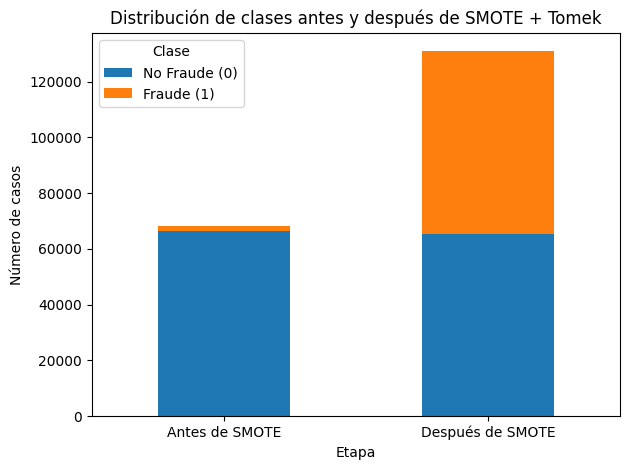

Conteo de clases:
fraude                0      1
Antes de SMOTE    66356   1878
Después de SMOTE  65455  65455


In [7]:
# === 7. División y balanceo de clases ===
# Dividir X y y junto con identificadores
X_train_base, X_test_base, y_train, y_test, id_train, id_test = train_test_split(
    X, y, identificadores, stratify=y, test_size=0.3, random_state=42
)

# No aplicamos escalado, usamos directamente las bases
X_train = X_train_base
X_test = X_test_base

# Aplicar SMOTE + Tomek
smote_tomek = SMOTETomek(random_state=42)
X_res, y_res = smote_tomek.fit_resample(X_train, y_train)

# Visualizar balance de clases
df_balance = pd.DataFrame({
    "Antes de SMOTE": y_train.value_counts(),
    "Después de SMOTE": y_res.value_counts()
}).T

df_balance.plot(kind="bar", stacked=True)
plt.title("Distribución de clases antes y después de SMOTE + Tomek")
plt.xlabel("Etapa")
plt.ylabel("Número de casos")
plt.legend(title="Clase", labels=["No Fraude (0)", "Fraude (1)"])
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

print("Conteo de clases:")
print(df_balance)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Mejores hiperparámetros encontrados:
{'criterion': 'entropy', 'max_depth': 30, 'max_features': 'sqrt', 'n_estimators': 300}

Reporte de clasificación del mejor modelo:
              precision    recall  f1-score   support

           0       0.98      0.93      0.95     28439
           1       0.11      0.32      0.17       805

    accuracy                           0.91     29244
   macro avg       0.55      0.62      0.56     29244
weighted avg       0.96      0.91      0.93     29244

Área Bajo la Curva (AUC) - Mejor Modelo: 0.7792


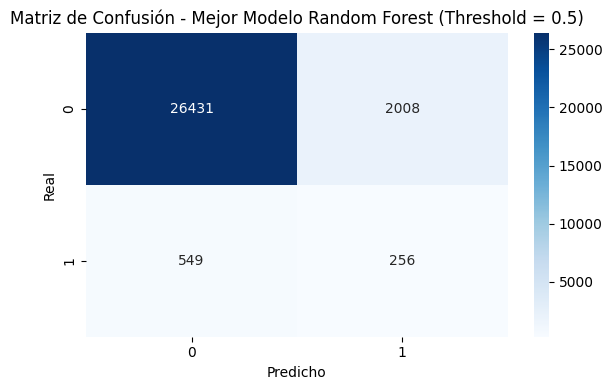

In [8]:
# === 8. Entrenamiento y evaluación con Random Forest usando GridSearchCV ===
# Definir la grilla de hiperparámetros
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'max_features': [5, 'sqrt', 'log2'],
    'criterion': ['gini', 'entropy']
}

# Instanciar el modelo base
rf_model = RandomForestClassifier(
    random_state=42,
    n_jobs=-1
)

# Configurar GridSearchCV priorizando recall
grid_search_rf = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    scoring='recall',  # Prioriza sensibilidad
    cv=5,
    verbose=2,
    n_jobs=-1
)

# Ejecutar la búsqueda
grid_search_rf.fit(X_res, y_res)

# Mostrar los mejores parámetros encontrados
print("Mejores hiperparámetros encontrados:")
print(grid_search_rf.best_params_)

# Usar el mejor modelo para predecir
mejor_modelo_rf = grid_search_rf.best_estimator_
y_pred_prob_best = mejor_modelo_rf.predict_proba(X_test)[:, 1]
threshold = 0.5
y_pred_threshold_best = (y_pred_prob_best >= threshold).astype(int)

# Reporte de resultados
print("\nReporte de clasificación del mejor modelo:")
print(classification_report(y_test, y_pred_threshold_best))

# AUC
auc_score_best = roc_auc_score(y_test, y_pred_prob_best)
print(f"Área Bajo la Curva (AUC) - Mejor Modelo: {auc_score_best:.4f}")

# Matriz de confusión
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_threshold_best), annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de Confusión - Mejor Modelo Random Forest (Threshold = 0.5)")
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.tight_layout()
plt.savefig("matriz_confusion_rf05.png", dpi=300, bbox_inches='tight')  # Guardar imagen
plt.show()

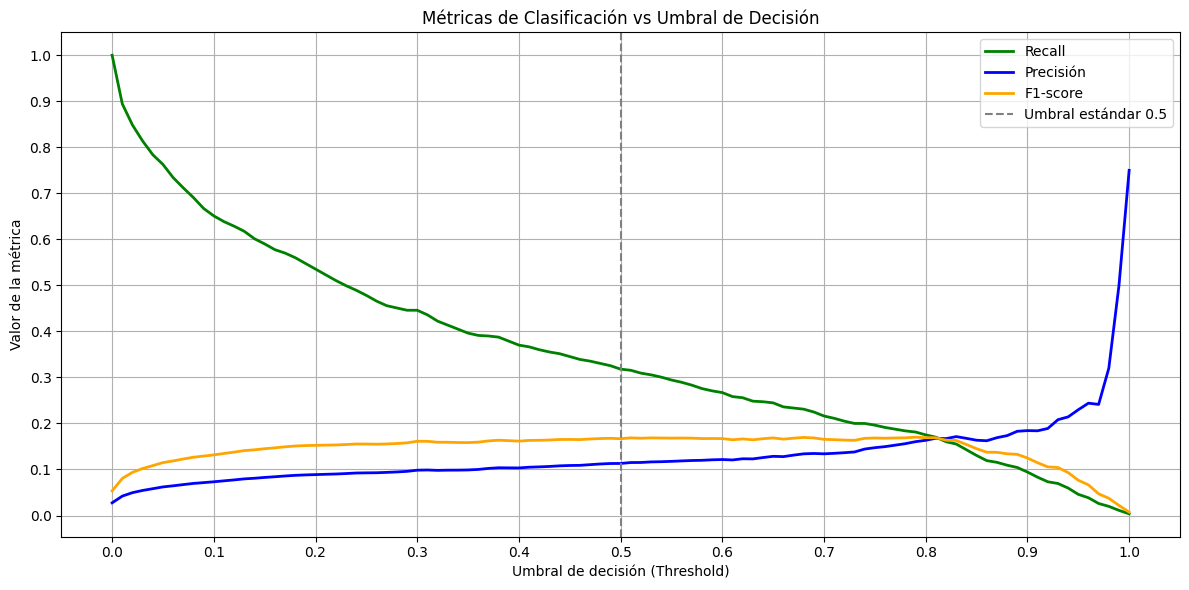

In [9]:
# === 9. Análisis del Umbral de Decisión: Curvas de Recall, Precisión y F1-score ===
# Inicializar listas
thresholds = np.arange(0.0, 1.01, 0.01)
recalls = []
precisions = []
f1_scores = []

# Calcular métricas para cada threshold
for t in thresholds:
    y_pred_t = (y_pred_prob_best >= t).astype(int)
    recalls.append(recall_score(y_test, y_pred_t))
    precisions.append(precision_score(y_test, y_pred_t, zero_division=0))
    f1_scores.append(f1_score(y_test, y_pred_t))

# Graficar
plt.figure(figsize=(12, 6))
plt.plot(thresholds, recalls, label='Recall', color='green', linewidth=2)
plt.plot(thresholds, precisions, label='Precisión', color='blue', linewidth=2)
plt.plot(thresholds, f1_scores, label='F1-score', color='orange', linewidth=2)
plt.axvline(0.5, color='gray', linestyle='--', label='Umbral estándar 0.5')
plt.title("Métricas de Clasificación vs Umbral de Decisión")
plt.xlabel("Umbral de decisión (Threshold)")
plt.ylabel("Valor de la métrica")
plt.xticks(np.arange(0.0, 1.05, 0.1))
plt.yticks(np.linspace(0, 1, 11))
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

=== Reporte de clasificación (Threshold = 0.01) ===
              precision    recall  f1-score   support

           0       0.99      0.42      0.59     28439
           1       0.04      0.89      0.08       805

    accuracy                           0.44     29244
   macro avg       0.52      0.66      0.34     29244
weighted avg       0.97      0.44      0.58     29244

Área Bajo la Curva (AUC): 0.7792


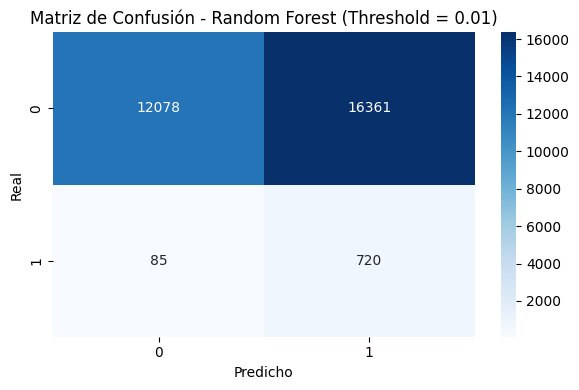

In [10]:
# === 10. Evaluación del Mejor Random Forest - Threshold ajustado (0.01) ===
# Reutilizar el modelo ya entrenado
y_pred_prob = mejor_modelo_rf.predict_proba(X_test)[:, 1]
threshold = 0.01  # Umbral ajustado para mejorar recall
y_pred_threshold = (y_pred_prob >= threshold).astype(int)

# Reporte de métricas
print("=== Reporte de clasificación (Threshold = 0.01) ===")
print(classification_report(y_test, y_pred_threshold))

# Calcular AUC
auc_score = roc_auc_score(y_test, y_pred_prob)
print(f"Área Bajo la Curva (AUC): {auc_score:.4f}")

# Matriz de confusión
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_threshold), annot=True, fmt='d', cmap='Blues')
plt.title(f"Matriz de Confusión - Random Forest (Threshold = {threshold})")
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.tight_layout() 
plt.savefig("matriz_confusion_rf001.png", dpi=300, bbox_inches='tight')
plt.show()

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Mejores hiperparámetros encontrados:
{'colsample_bytree': 1, 'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}

Reporte de clasificación (Threshold = 0.5):
              precision    recall  f1-score   support

           0       0.99      0.87      0.92     28439
           1       0.10      0.54      0.17       805

    accuracy                           0.86     29244
   macro avg       0.54      0.70      0.55     29244
weighted avg       0.96      0.86      0.90     29244

Área Bajo la Curva (AUC): 0.7975


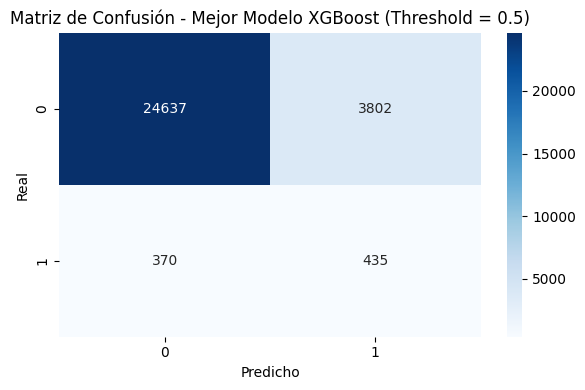

In [11]:
# === 11. Entrenamiento y evaluación con XGBoost usando GridSearchCV ===
# Grilla de hiperparámetros
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1, 0.3],
    'max_depth': [3, 5],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}

# Modelo base
xgb_model = XGBClassifier(
    random_state=42,
    n_jobs=-1,
    eval_metric='aucpr',
    use_label_encoder=False
)

# Configurar GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='recall',
    cv=5,
    verbose=2,
    n_jobs=-1
)

# Entrenar búsqueda
grid_search.fit(X_res, y_res)

# Mostrar mejores hiperparámetros
print("Mejores hiperparámetros encontrados:")
print(grid_search.best_params_)

# Evaluar mejor modelo con threshold = 0.5
mejor_modelo_xgb = grid_search.best_estimator_
y_pred_prob_best = mejor_modelo_xgb.predict_proba(X_test)[:, 1]
y_pred_threshold_best = (y_pred_prob_best >= 0.5).astype(int)

# Reporte
print("\nReporte de clasificación (Threshold = 0.5):")
print(classification_report(y_test, y_pred_threshold_best))

# AUC
auc_score_best = roc_auc_score(y_test, y_pred_prob_best)
print(f"Área Bajo la Curva (AUC): {auc_score_best:.4f}")

# Matriz de confusión
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_threshold_best), annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de Confusión - Mejor Modelo XGBoost (Threshold = 0.5)")
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.tight_layout()
plt.savefig("matriz_confusion_xgboost05.png", dpi=300, bbox_inches='tight')  # Guardar imagen
plt.show()

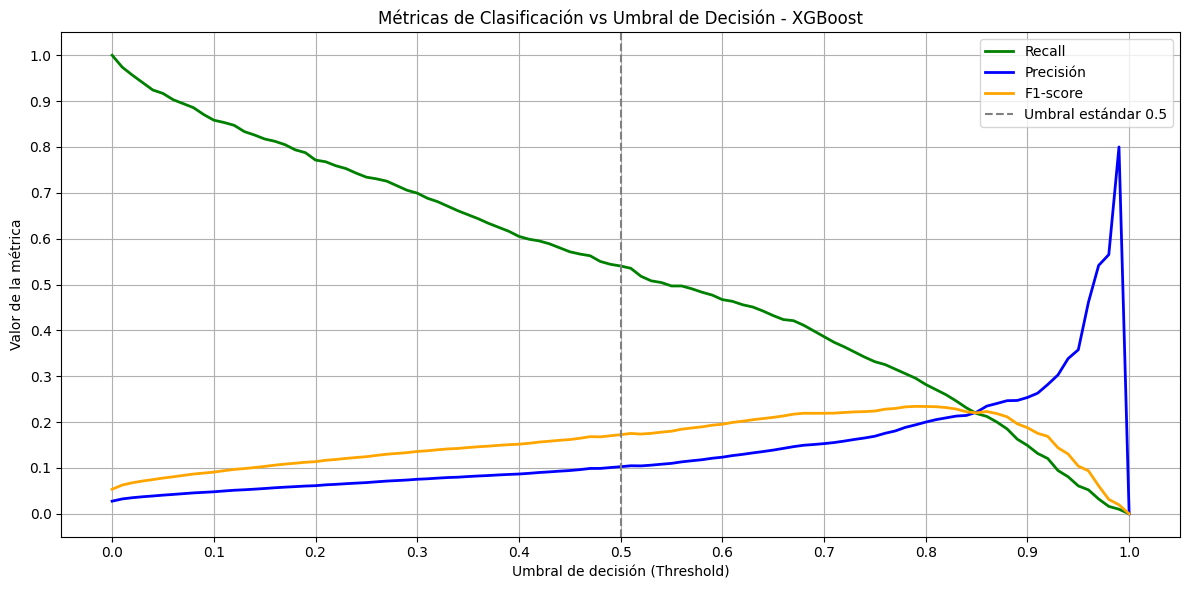

In [12]:
# === 12. Análisis del Umbral de Decisión con XGBoost: Curvas de Recall, Precisión y F1-score ===
# Inicializar listas
thresholds = np.arange(0.0, 1.01, 0.01)
recalls = []
precisions = []
f1_scores = []

# Calcular métricas para cada threshold
for t in thresholds:
    y_pred_t = (y_pred_prob_best >= t).astype(int)
    recalls.append(recall_score(y_test, y_pred_t))
    precisions.append(precision_score(y_test, y_pred_t, zero_division=0))
    f1_scores.append(f1_score(y_test, y_pred_t))

# Graficar
plt.figure(figsize=(12, 6))
plt.plot(thresholds, recalls, label='Recall', color='green', linewidth=2)
plt.plot(thresholds, precisions, label='Precisión', color='blue', linewidth=2)
plt.plot(thresholds, f1_scores, label='F1-score', color='orange', linewidth=2)
plt.axvline(0.5, color='gray', linestyle='--', label='Umbral estándar 0.5')
plt.title("Métricas de Clasificación vs Umbral de Decisión - XGBoost")
plt.xlabel("Umbral de decisión (Threshold)")
plt.ylabel("Valor de la métrica")
plt.xticks(np.arange(0.0, 1.05, 0.1))
plt.yticks(np.linspace(0, 1, 11))
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

=== Reporte de clasificación (Threshold = 0.01) ===
              precision    recall  f1-score   support

           0       1.00      0.18      0.30     28439
           1       0.03      0.97      0.06       805

    accuracy                           0.20     29244
   macro avg       0.51      0.58      0.18     29244
weighted avg       0.97      0.20      0.29     29244

Área Bajo la Curva (AUC): 0.7975


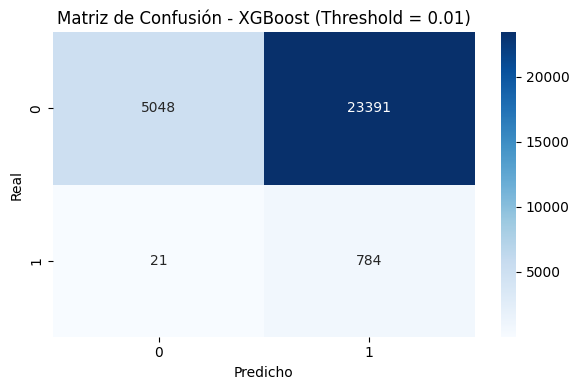

In [13]:
# === 13. Evaluación del Mejor XGBoost - Threshold ajustado (0.01) ===
# Ya fue entrenado: reutilizamos mejor_modelo_xgb y y_pred_prob_best
threshold = 0.01  # Umbral ajustado para mayor recall
y_pred_threshold = (y_pred_prob_best >= threshold).astype(int)

# Reporte de métricas
print(f"=== Reporte de clasificación (Threshold = {threshold}) ===")
print(classification_report(y_test, y_pred_threshold))

# Calcular AUC
auc_score = roc_auc_score(y_test, y_pred_prob_best)
print(f"Área Bajo la Curva (AUC): {auc_score:.4f}")

# Matriz de confusión
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_threshold), annot=True, fmt='d', cmap='Blues')
plt.title(f"Matriz de Confusión - XGBoost (Threshold = {threshold})")
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.tight_layout()
plt.savefig("matriz_confusion_xgboost001.png", dpi=300, bbox_inches='tight')  # Guardar imagen
plt.show()